In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from libs import plot_exponential_growth, fmt_worktime
from params import doubling_time

GPT5_LAUNCH_DATE = datetime(2025, 8, 7)
O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)
CLAUDE4_LAUNCH_DATE = datetime(2025, 5, 22)

print("Loaded libraries")

## START task length (displayed in sec) ##
{1: 1.0,
 5: 1.0,
 10: 1.0,
 20: 1.0,
 30: 1.88,
 40: 3.95,
 50: 7.81,
 60: 15.2,
 70: 30.64,
 80: 69.5,
 90: 218.19,
 95: 571.97,
 99: 3228.62}



## AGI task length (displayed in hrs) ##
{1: 40,
 5: 50,
 10: 80,
 20: 139,
 30: 205,
 40: 290,
 50: 398,
 60: 549,
 70: 773,
 80: 1156,
 90: 2014,
 95: 3153,
 99: 7485}



## DOUBLING TIME (displayed in days) ##
{1: 95,
 5: 118,
 10: 118,
 20: 118,
 30: 135,
 40: 160,
 50: 186,
 60: 212,
 70: 212,
 80: 212,
 90: 221,
 95: 251,
 99: 315}



## SHIFT (displayed in days) ##
{1: 0,
 5: 31,
 10: 56,
 20: 89,
 30: 112,
 40: 132,
 50: 150,
 60: 168,
 70: 188,
 80: 212,
 90: 243,
 95: 270,
 99: 319}
Loaded libraries


In [9]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
print("METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: GPT5 at 2.28hr on {GPT5_LAUNCH_DATE.strftime('%Y-%m-%d')}")
print("=" * 70)
print()


# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)


quarters = []
for year in range(2025, 2030):
    start_q = 3 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)

print(
    f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}"
)
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_gpt5 = (quarter_date - GPT5_LAUNCH_DATE).days

    if days_from_gpt5 < 0:
        continue

    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        doublings = days_from_gpt5 / tau_samples[i]
        task_lengths[i] = 2.28 * (2**doublings)

    task_lengths = np.minimum(task_lengths, 2000)

    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)

    ci_str = f"[{fmt_worktime(p5)} - {fmt_worktime(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")

    print(
        f"{year}Q{q:<7} {date_str:<12} {fmt_worktime(mean_val):<10} {fmt_worktime(median_val):<10} {ci_str:<25} {days_from_gpt5:>4}"
    )

    results.append(
        {
            "quarter": f"{year}Q{q}",
            "date": quarter_date,
            "mean": mean_val,
            "median": median_val,
            "p5": p5,
            "p95": p95,
            "days": days_from_gpt5,
            "task_lengths": task_lengths,
        }
    )

    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [
    (2, "2 hours"),
    (4, "4 hours"),
    (8, "1 day"),
    (16, "2 days"),
    (24, "3 days"),
    (40, "1 week"),
    (174, "1 month"),
]

for hours, name in milestones:
    for r in results:
        if r["median"] >= hours:
            prob = np.mean(r["task_lengths"] >= hours) * 100
            date_str = r["date"].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: GPT5 at 2.28hr on 2025-08-07

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------
2025Q3       2025-09-30   3.5hr      3.5hr      [3.5hr - 3.5hr]             54
2025Q4       2025-12-31   7.0hr      7.0hr      [7.0hr - 7.0hr]            146

2026Q1       2026-03-31   1.8d       1.8d       [1.8d - 1.8d]              236
2026Q2       2026-06-30   3.5d       3.5d       [3.5d - 3.5d]              327
2026Q3       2026-09-30   1.4wk      1.4wk      [1.4wk - 1.4wk]            419
2026Q4       2026-12-31   2.9wk      2.9wk      [2.9wk - 2.9wk]            511

2027Q1       2027-03-31   5.8wk      5.8wk      [5.8wk - 5.8wk]            601
2027Q2       2027-06-30   11.8wk     11.8wk     [11.8wk - 11.8wk]          692
2027Q3       2027-09-30   23.9wk     23.9wk     [23.9wk - 23.9wk]          784
2027Q4       2027-12-3

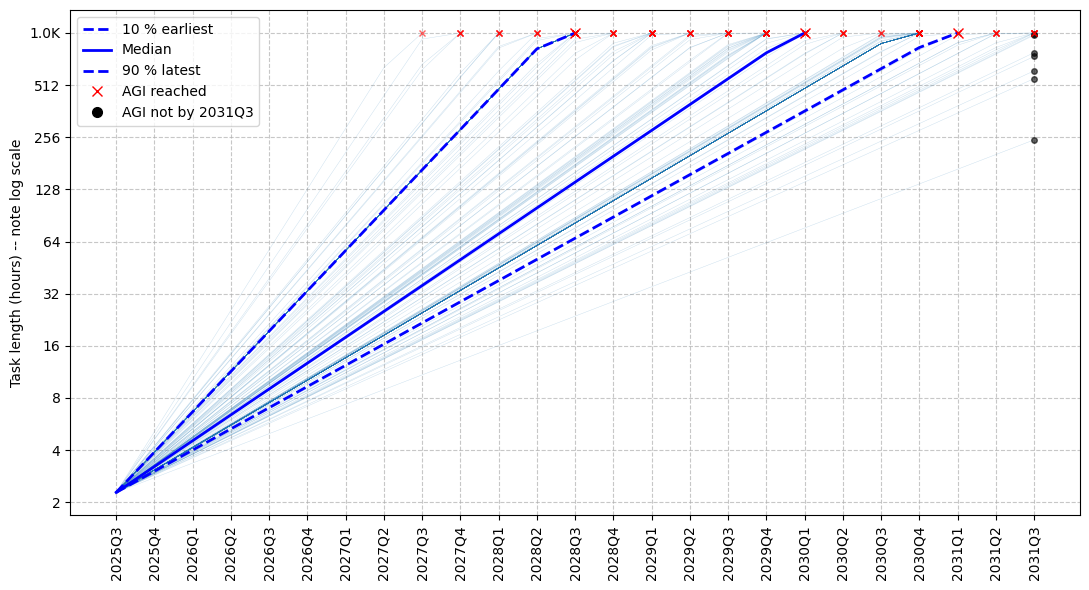

In [3]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    start_hours=2.28,
    start_date=datetime(2025, 8, 7),
    agi_task_length=100_000,
    shift=0,
    n_quarters=24,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

In [4]:
print("PREDICT O3 -> CLAUDE 4")
days_since_o3 = (CLAUDE4_LAUNCH_DATE - O3_LAUNCH_DATE).days

def model():
    doublings = days_since_o3 / doubling_time
    return 1.75 * (2**doublings)


print("Model predictions for Claude 4")
mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(
    f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})"
)
print("Actual observed: Claude 4 Opus at ~1.1-1.3 hours")

PREDICT O3 -> CLAUDE 4
Model predictions for Claude 4
Predicted: 2.0hr (1.9hr - 2.2hr)
Actual observed: Claude 4 Opus at ~1.1-1.3 hours


In [5]:
print("PREDICT O3 -> GPT5")
days_since_o3 = (GPT5_LAUNCH_DATE - O3_LAUNCH_DATE).days

def model():
    doublings = days_since_o3 / doubling_time
    return 1.75 * (2**doublings)


print("Model predictions for GPT5")
mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(
    f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})"
)
print("Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)")

PREDICT O3 -> GPT5
Model predictions for GPT5
Predicted: 2.9hr (2.4hr - 3.4hr)
Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)


In [6]:
print("Sanity Check - Current State (GPT5 -> NOW)")

today = datetime(2025, 9, 10)
days_since_gpt5 = (today - GPT5_LAUNCH_DATE).days
print("")
print(f"Days since GPT5: {days_since_gpt5}")
print("")
print(f"Model predictions for PUBLIC models on {today.date()}")


def model():
    doublings = days_since_gpt5 / doubling_time
    return 2.28 * (2**doublings)


mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(
    f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})"
)
print("Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)")

Sanity Check - Current State (GPT5 -> NOW)

Days since GPT5: 34

Model predictions for PUBLIC models on 2025-09-10
Predicted: 2.6hr (2.5hr - 2.8hr)
Actual observed: GPT5 at ~2.28hrs (1-4.5hrs)


In [8]:
days_since_o3 = (today - O3_LAUNCH_DATE).days
doubling_time = 90
acceleration = 0.97

def model():
    doublings = days_since_o3 / doubling_time
    effective_doublings = doublings ** acceleration
    return 1.75 * (2 ** effective_doublings)

print("Model predictions for today")
mean_ci = sq.get_mean_and_ci(sq.sample(model, n=50_000))
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")

Model predictions for today
Predicted: 5.3hr (5.3hr - 5.3hr)
